# Simple Regression Data

> Data simulated to adhere to standard OLS assumptions

In [ ]:
#| default_exp synthetic_data.simple_regression_data

In [ ]:
#| hide
from nbdev.showdoc import *
import pprint
from itertools import product
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import pymc as pm
from tueplots import bundles
from tueplots.constants.color import rgb
import seaborn as sns

In [ ]:
#| hide
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#| export
#| hide
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from typing import Optional


In [ ]:
#| hide
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
#| export 
def generate_ols_data(
    sample_size: int,
    n_exogenous_vars: int, # Number of variables with a direct effect on the dep var
    n_confounder: int=0, # Number of confounder variables to include
    noise_sigma: float=1.0, # Level of un-explained gaussian noise to add
    random_seed: Optional[int]=None # Random seed for reproducability
) -> xr.Dataset: # Generated Data
    "Generate Simple OLS data"
    
    rng = np.random.default_rng(random_seed)
    data = rng.normal(0, 1, size=(sample_size, n_exogenous_vars))
    var_names = [f'var_{i}' for i in range(n_exogenous_vars)]
    df = pd.DataFrame(data, columns=var_names)
    df["Index"] = np.arange(sample_size)
    df.set_index("Index", inplace=True)
    if n_confounder > 0:
        con_names = [f"con_{i}" for i in range(n_confounder)]
        df[con_names] = rng.normal(0, 1, size=(sample_size, n_confounder))
        betas_confounds = rng.normal(0, .4, size = (n_confounder, n_exogenous_vars))
        df[var_names] = df[var_names].values + df[con_names].values @ betas_confounds
    betas = np.round(rng.normal(0, 2, size=n_exogenous_vars), 3)
    betas_confounds = np.round(rng.normal(0, .4, size=n_confounder), 3)
    alpha = np.round(rng.normal(0, 3), 3)
    dep_var = data @ betas + df[con_names].values @ betas_confounds + alpha + noise_sigma*rng.normal(0, 1, size=sample_size)
    df['depvar'] = dep_var
    dataset = xr.Dataset.from_dataframe(df)
    dataset = dataset.assign_attrs(
        true_betas = {
            name: betas[i] for i, name in enumerate(var_names)
            }| {name: betas_confounds[i] for i, name in enumerate(con_names)},
        true_alpha=alpha
        )

    
    return dataset

In [ ]:
SAMPLE_SIZE = 156
N_INDEPVAR = 2
N_CONFOUNDER = 2
NOISE_SIGMA = 1
RANDOM_SEED = 42

data = generate_ols_data(
    SAMPLE_SIZE, N_INDEPVAR, 
    n_confounder=N_CONFOUNDER,
    noise_sigma=NOISE_SIGMA, 
    random_seed=RANDOM_SEED)
data.head()

<xarray.Dataset> Size: 240B
Dimensions:  (Index: 5)
Coordinates:
  * Index    (Index) int64 40B 0 1 2 3 4
Data variables:
    var_0    (Index) float64 40B 0.5611 0.9553 -1.824 0.5083 0.162
    var_1    (Index) float64 40B -1.173 0.6022 -1.697 -1.17 -1.124
    con_0    (Index) float64 40B 1.744 0.828 0.06655 0.9896 0.7824
    con_1    (Index) float64 40B 0.439 -0.2966 -0.6974 -1.178 -0.1907
    depvar   (Index) float64 40B 2.803 -7.397 8.174 -0.7104 2.132
Attributes:
    true_betas:  {'var_0': -2.081, 'var_1': -4.826, 'con_0': 0.644, 'con_1': ...
    true_alpha:  -1.216

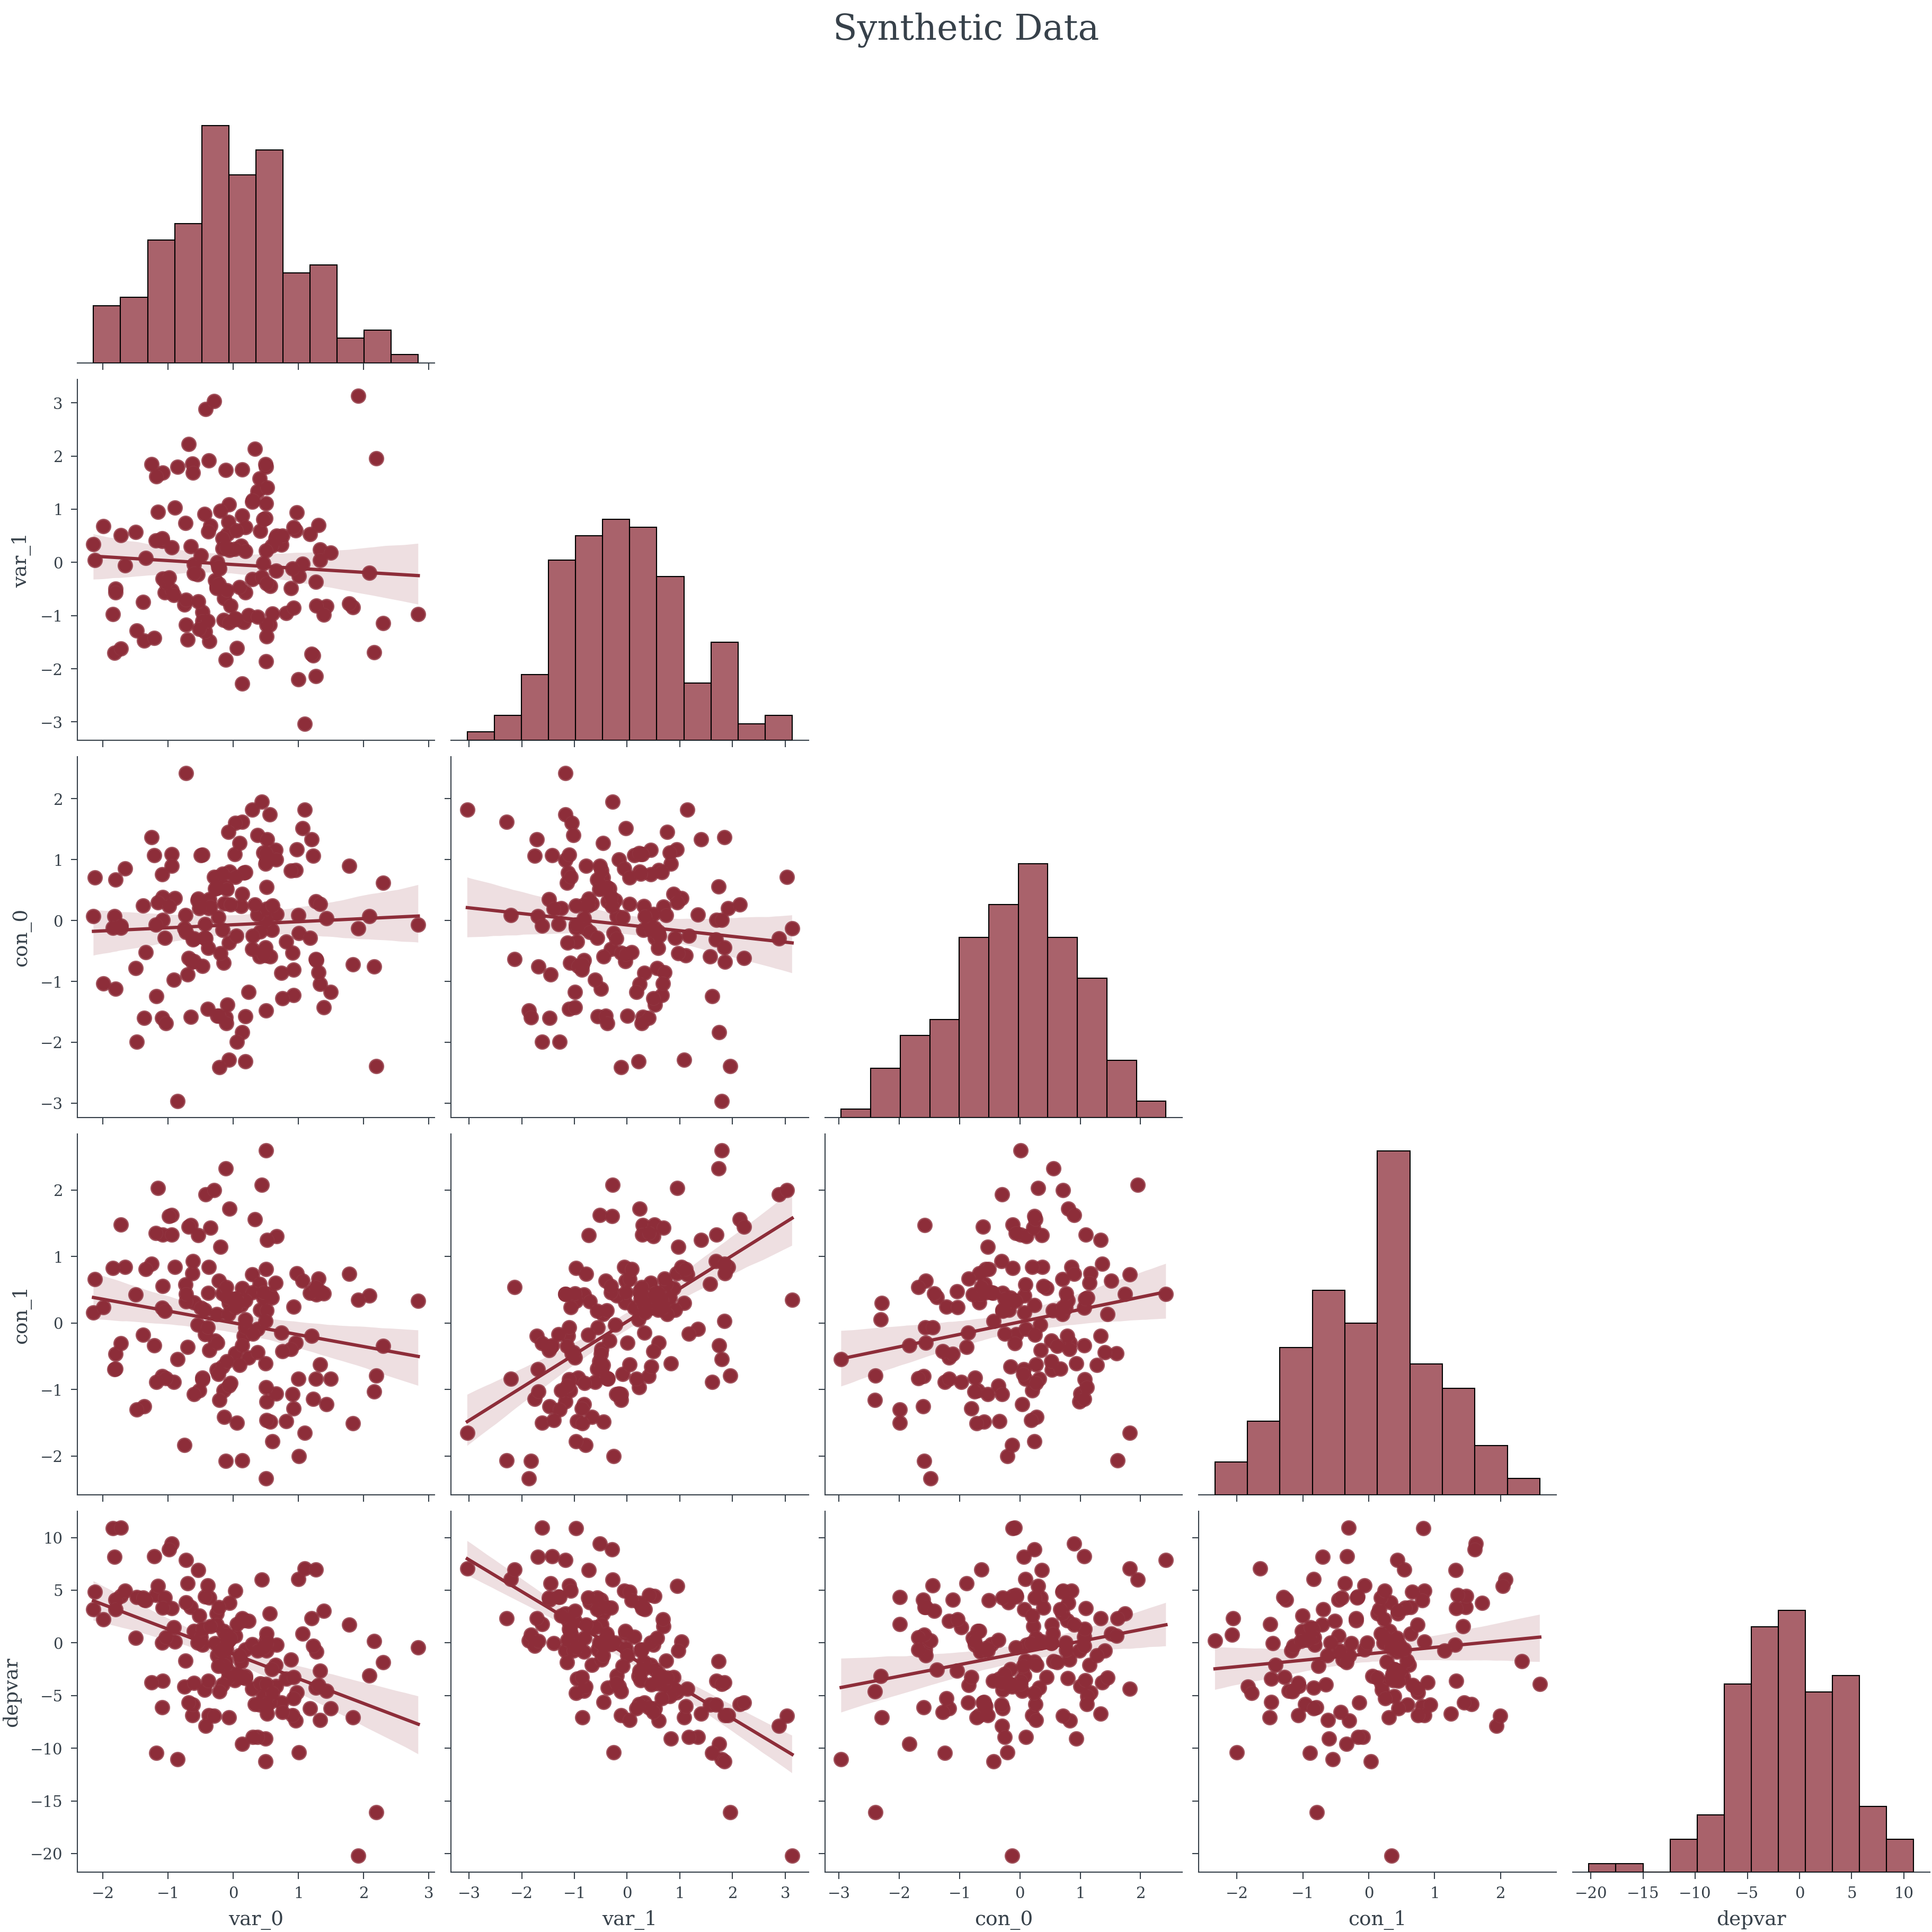

In [ ]:
#| echo: false
#| label: fig-synthetic-pair-plot
#| fig-cap: Sythetic Data
graph = sns.pairplot(data.to_dataframe(), corner=True)
graph.map_lower(sns.regplot)
graph.fig.suptitle("Synthetic Data", fontsize=16);

In [ ]:
#| echo: false
#| label: tbl-ols-on-synthetic-data
#| tbl-cap: OLS on synthetic data without controlling for confounds
ols_model = sm.OLS(
    endog = data.depvar.to_series(), 
    exog = sm.add_constant(
        data[['var_0', 'var_1']]
        .to_dataframe()
        )
    ).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 depvar   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     165.3
Date:                Sun, 03 Nov 2024   Prob (F-statistic):           5.85e-39
Time:                        20:41:00   Log-Likelihood:                -385.98
No. Observations:                 156   AIC:                             778.0
Df Residuals:                     153   BIC:                             787.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1773      0.232     -5.065      0.000      -1.636      -0.718
var_0         -2.5834      0.238    -10.853      0.000      -3.054      -2.113
var_1         -3.1556      0.207    -15.251      0.000      -3.564      -2.747
==============================================================================
Omnibus:                        0.268   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.875   Jarque-Bera (JB):                0.061
Skew:                           0.006   Prob(JB):                        0.970
Kurtosis:                       3.097   Cond. No.                         1.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

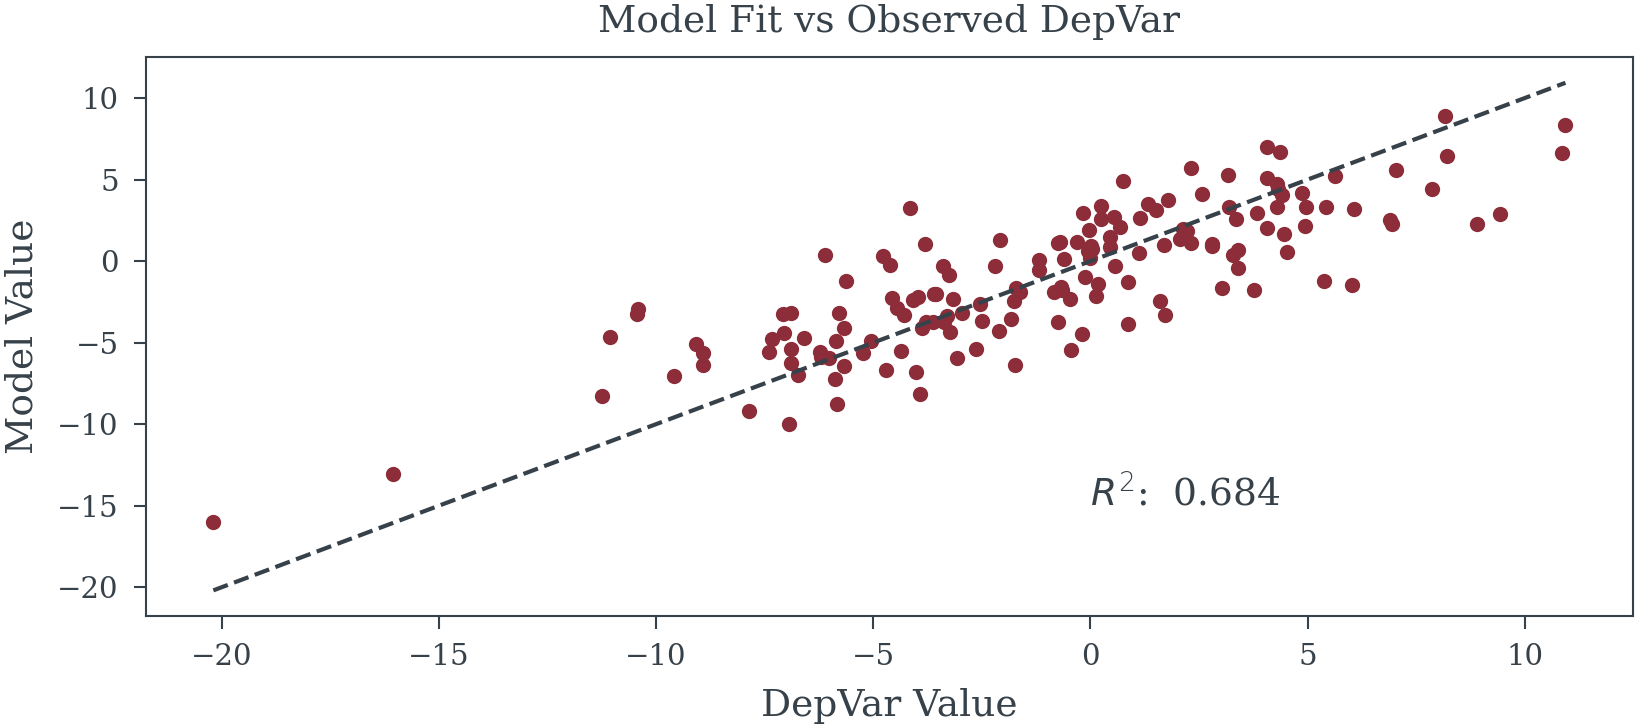

In [ ]:
#| echo: false
#| label: fig-ols-on-synthetic-data
#| fig-cap: OLS fit on synthetic data without controlling for confounds
plt.figure()
plt.scatter(data.depvar, ols_model.predict(), s=10)
plt.plot(
    [data.depvar.min(), data.depvar.max()], 
    [data.depvar.min(), data.depvar.max()], 
    ls='--', color='C1')
#plt.plot(data.Index, ols_model.predict(), color='C1', label="Model Fit")
plt.text(0, -15, f"$R^2$: {r2_score(data.depvar, ols_model.predict()): 0.3f}")
plt.title("Model Fit vs Observed DepVar")
plt.xlabel("DepVar Value")
plt.ylabel("Model Value");

In [ ]:
#| echo: false
#| label: tbl-ols-on-synthetic-data-controlled
#| tbl-cap: OLS on synthetic data controlling for confounds
ols_model = sm.OLS(
    endog = data.depvar.to_series(), 
    exog = sm.add_constant(
        data[[
            'var_0', 'var_1', 
            'con_0', 'con_1'
            ]]
        .to_dataframe()
        )
    ).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 depvar   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     921.0
Date:                Sun, 03 Nov 2024   Prob (F-statistic):          6.40e-105
Time:                        20:41:01   Log-Likelihood:                -223.44
No. Observations:                 156   AIC:                             456.9
Df Residuals:                     151   BIC:                             472.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2551      0.083    -15.145      0.000      -1.419      -1.091
var_0         -2.1015      0.086    -24.360      0.000      -2.272      -1.931
var_1         -4.8119      0.093    -51.774      0.000      -4.996      -4.628
con_0          0.0174      0.086      0.203      0.840      -0.153       0.187
con_1          3.3958      0.110     30.773      0.000       3.178       3.614
==============================================================================
Omnibus:                        1.168   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                1.216
Skew:                          -0.132   Prob(JB):                        0.544
Kurtosis:                       2.657   Cond. No.                         2.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

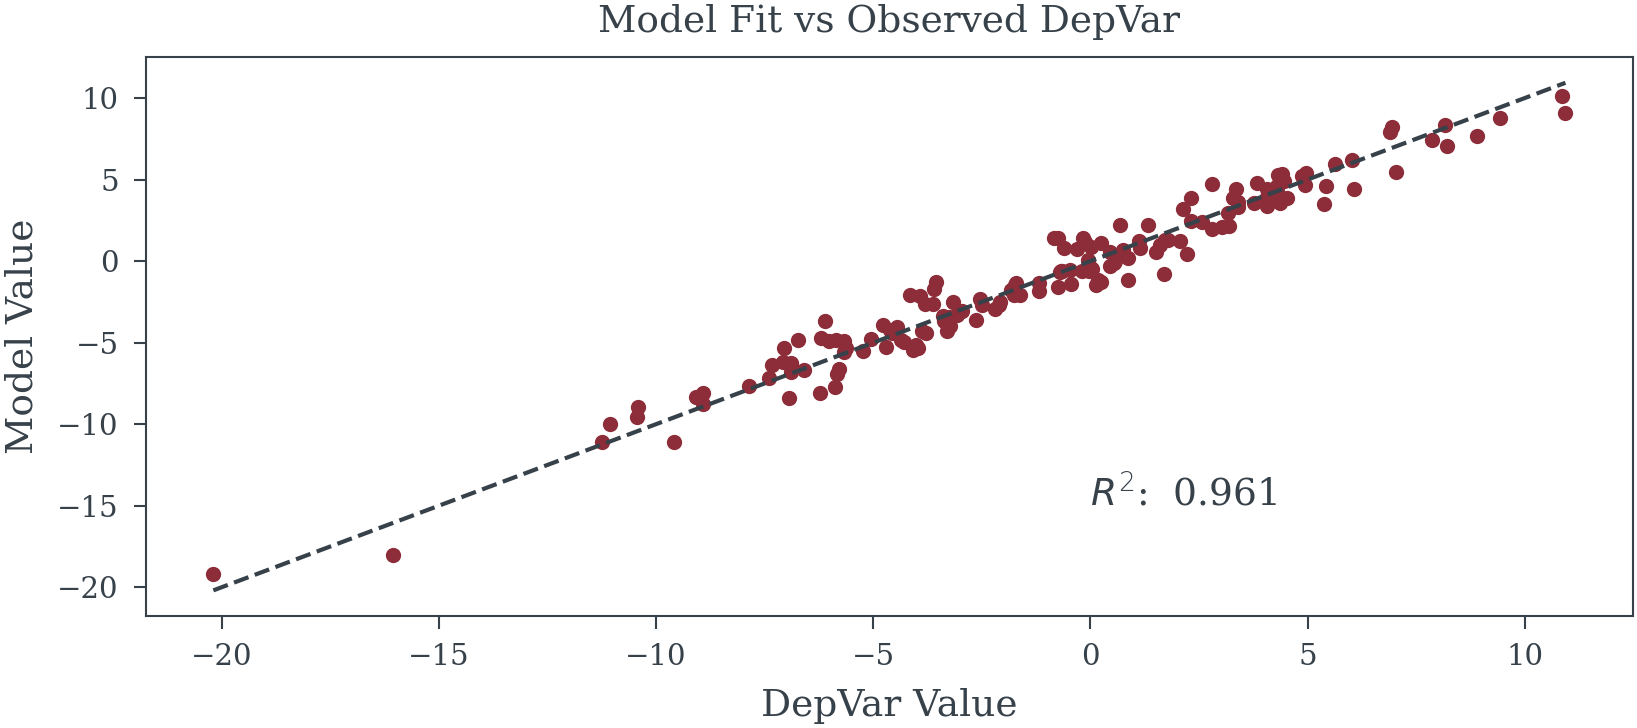

In [ ]:
#| echo: false
#| label: fig-ols-on-synthetic-data-controlled
#| fig-cap: OLS fit on synthetic data controlling for confounds
plt.figure()
plt.scatter(data.depvar, ols_model.predict(), s=10)
plt.plot(
    [data.depvar.min(), data.depvar.max()], 
    [data.depvar.min(), data.depvar.max()], 
    ls='--', color='C1')
#plt.plot(data.Index, ols_model.predict(), color='C1', label="Model Fit")
plt.text(0, -15, f"$R^2$: {r2_score(data.depvar, ols_model.predict()): 0.3f}")
plt.title("Model Fit vs Observed DepVar")
plt.xlabel("DepVar Value")
plt.ylabel("Model Value");

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()